# GAN-Understanding
### In this notebook, I attempt to understand and explain the concept of generative adversarial training of Neural Networks

import the required packages:

In [124]:
import matplotlib.pyplot as plt # for visualization
import matplotlib.animation as animation
import numpy as np

from IPython.display import HTML

# import pytorch
import torch as th

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

import math

# to plot the images inline
%matplotlib inline

In [125]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [126]:
# check the structure of the project directory
exec_command(['ls', '.'])

GAN-U.ipynb
LICENSE
README.md



In [127]:
# set a seed value for the script
seed_value = 3

In [128]:
np.random.seed(seed_value)

Set the constants for the script

In [129]:
# Hyperparameters for tweaking ...
# ==============================================================================
Real_gaussian = {
    'mu': -3,
    'sigma': 0.4
}

plot_x_lim = (-5, 10)
plot_y_lim = (0, 2)
# ==============================================================================

Following class allows for creation of an arbitrary Gaussian distribution and allows us to draw samples from it as required

### Setup the Gaussian data creation mechanism

In [130]:
# setup a gaussian distribution:
class GaussianDistribution:
    """
        defines a gaussian distribution of data
        :param mu: mean 
        :param sigma: standard deviation
        :param ndims: number of dimensions of the data. default = 1
    """
    
    def __init__(self, mu, sigma, ndims=1):
        self.mu = mu
        self.sigma = sigma
        self.ndims = ndims
        
    def draw_samples(self, N):
        """
        draw samples from this gaussian
        :param N: number of samples required
        :return: ndarray => drawn samples [N x ndims]
        """
        samps = np.random.normal(self.mu, self.sigma, size=(N, self.ndims))
        sorted_samps = np.array(sorted(samps, key=lambda x: np.linalg.norm(x)))
        return sorted_samps

### Setup the 1-D plotting mechanism

In [131]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [132]:
def plot_data(samps, x_spaces, labels=('real_data', 'fake_data'), 
              scatter=False, fig_size=(12, 5)):
    assert len(samps) == len(labels), "Label names for the plotting data are incompatible"
        
    plt.figure(figsize=fig_size)
    plt.grid(True, which="both")
    
    for samp, x_space, label in zip(samps, x_spaces, labels):
        if scatter:
            plt.scatter(x_space, samp, label=label)
        else:
            plt.plot(x_space, samp, label=label)
    
    plt.xlim(*plot_x_lim)
    plt.ylim(*plot_y_lim)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()

In [133]:
def get_pdf(samps, num_bins=100):
    bins = np.squeeze(np.linspace(min(samps) - 1, max(samps) + 1, num=num_bins))
    pdf, _ = np.histogram(samps, bins=bins, density=True)
    x_ = np.linspace(min(samps) - 1, max(samps) + 1, len(pdf))
    
    return pdf, x_

Test a few different gaussian distributions:

In [134]:
g1 = GaussianDistribution(3, 0.7)
g2 = GaussianDistribution(5, 0.3)

In [135]:
pg1, pg1_x = get_pdf(g1.draw_samples(10000))

In [136]:
pg2, pg2_x = get_pdf(g2.draw_samples(10000))

In [137]:
x_ = np.linspace(5, 16, 1000)
decision_boundary = list(map(lambda x: sigmoid(x - 11), x_))

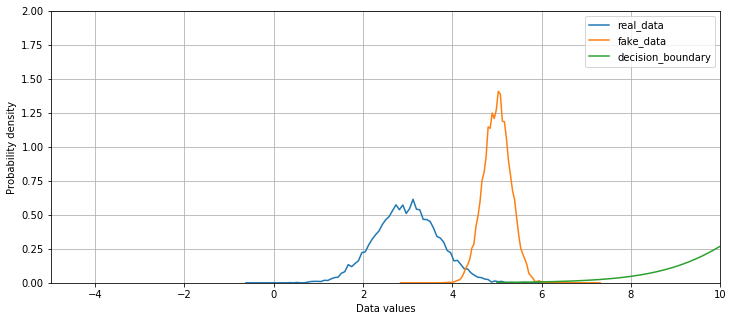

In [138]:
plot_data((pg1, pg2, decision_boundary), (pg1_x, pg2_x, x_), ('real_data', 'fake_data', 'decision_boundary'))

### Setup the animation mechanism

In [139]:
def get_animation(plots, xs, fig_size=(12, 5), scatter=False):
    
    assert len(plots) == len(xs), "plots and xs lengths not compatible"
    
    f, ax = plt.subplots(figsize=fig_size);
    ax.grid(True, which="both")
    f.suptitle('1D Generative Adversarial Network', fontsize=15)
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    
    if scatter:
        line_db = ax.scatter([], [], label='decision boundary');
        line_pd = ax.scatter([], [], label='real data');
        line_pg = ax.scatter([], [], label='generated data');
    else:
        line_db, = ax.plot([], [], label='decision boundary');
        line_pd, = ax.plot([], [], label='real data');
        line_pg, = ax.plot([], [], label='generated data');
    
    frame_number = ax.text(
        0.02,
        0.95,
        '',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes
    )
    
    ax.legend()

    def init():
        if scatter:
            line_db.set_offsets([[], []])
            line_pd.set_offsets([[], []])
            line_pg.set_offsets([[], []])
        else:
            line_db.set_data([], [])
            line_pd.set_data([], [])
            line_pg.set_data([], [])
        frame_number.set_text('')
        return (line_db, line_pd, line_pg, frame_number)

    def animate(i):
        db, pd, pg = plots[i]
        db_x, pd_x, pg_x = xs[i]
        
        min_val_x = min(min(db_x), min(pd_x), min(pg_x))
        max_val_x = max(max(db_x), max(pd_x), max(pg_x))
        min_val_y = min(min(db), min(pd), min(pg))
        max_val_y = max(max(db), max(pd), max(pg))
    
        ax.set_xlim(*plot_x_lim)
        ax.set_ylim(*plot_y_lim)
        
        frame_number.set_text(
            'Frame: {}/{}'.format(i, len(plots))
        )

        if scatter:
            line_db.set_offsets(list(zip(db_x, db)))
            line_pd.set_offsets(list(zip(pd_x, pd)))
            line_pg.set_offsets(list(zip(pg_x, pg)))
        else:
            line_db.set_data(db_x, db)
            line_pd.set_data(pd_x, pd)
            line_pg.set_data(pg_x, pg)

        return (line_db, line_pd, line_pg, frame_number)

    anim = animation.FuncAnimation(
        f,
        animate,
        init_func=init,
        frames=len(plots),
        blit=True
    )
    
    plt.close()
    return anim

In [140]:
plots, xs = [], []
for i in range(100):
    g_star = GaussianDistribution(6 + ((10 - 6) * (i / 100)), 0.3)
    pg_star, pg_star_x = get_pdf(g_star.draw_samples(10000))
    plots.append((decision_boundary, pg1, pg_star))
    xs.append((x_, pg1_x, pg_star_x))

In [141]:
anim = get_animation(plots, xs, scatter=False);
HTML(anim.to_html5_video())

## Now it's time to create the GAN

In [142]:
class DenseNet(th.nn.Module):
    
    def __init__(self, indims=1, outdims=1, depth=3, widths=[12, 12, 12], 
                 act_fn=th.nn.LeakyReLU(negative_slope=0.2)):
        
        assert len(widths) == depth, "widths' length and network depth are incompatible"
        
        super(DenseNet, self).__init__()
        
        # use the provided activation function
        self.act_fn = act_fn
        
        # add the required layers to the list:
        # add the first layer
        self.layers = th.nn.ModuleList([th.nn.Linear(indims, widths[0])])  # initialize the list 
        # with first layer
        
        # add the hidden layers
        for c_dep in range(depth - 1):
            self.layers.append(th.nn.Linear(widths[c_dep], widths[c_dep + 1]))
        
        # add the last layer
        self.layers.append(th.nn.Linear(widths[-1], outdims))

    def forward(self, x):
        # apply the neural Network:
        y = x
        for layer in self.layers:
            y = self.act_fn(layer(y))
        
        # return the so computed results:
        return y

In [143]:
# Generator and Discriminator are DenseNets so they inherit from it.
class Generator(DenseNet):
    pass

class Discriminator(DenseNet):
    pass

Interface for the Loss functions:

In [144]:
class GANLoss:
    """ Base class for all losses """

    def __init__(self, dis):
        self.dis = dis

    def dis_loss(self, real_samps, fake_samps):
        raise NotImplementedError("dis_loss method has not been implemented")

    # generally, for calculating the generator loss, the real samples are not required
    # But this interface has been created so for encompassing the contributions of the 
    # relativistic gan paper
    def gen_loss(self, real_samps, fake_samps):
        raise NotImplementedError("gen_loss method has not been implemented")

Procedure for training the GAN:

In [223]:
def train_gan(generator, discriminator, real_distribution, loss_fn, num_samps=10000,
              epochs=12, lr=0.0001, batch_size=32, feed_back_factor=30, scatter_animation=False,
              db_activation_fn=th.sigmoid):
    
    gen_optim = th.optim.Adam(generator.parameters(), lr=lr)
    dis_optim = th.optim.Adam(discriminator.parameters(), lr=lr)
    
    plots, xs = [], []
    
    print("Starting the training process ... ")
    for epoch in range(epochs):
        # draw real samples:
        real_samples_total = real_distribution.draw_samples(num_samps)
        
        total_batches = int(np.ceil(float(num_samps) / float(batch_size)))
        
        for batch in range(total_batches):
            start = batch * batch_size; end = start + batch_size
            real_samps = th.tensor(real_samples_total[start: end], dtype=th.float)
            
            # train the discriminator:
            # create fake samples
            z_latent = th.randn(len(real_samps), 1)
            fake_samps = generator(z_latent).detach()  # notice the detach from backpropagation

            dis_loss = loss_fn.dis_loss(real_samps, fake_samps)

            # three steps are required to update the parameters in PyTorch
            dis_optim.zero_grad()
            dis_loss.backward()
            dis_optim.step()

            # train the generator
            # create new fake samples
            z_latent = th.randn(len(real_samps), 1)
            fake_samps = generator(z_latent)

            gen_loss = loss_fn.gen_loss(real_samps, fake_samps)

            gen_optim.zero_grad()
            gen_loss.backward()
            gen_optim.step()
            
            if batch % (total_batches // feed_back_factor) == 0 or batch == 0:
                # add plots and xs for generating animation
                # create generated samples:
                temp_gen_samps = generator(th.randn(10000, 1)).detach().cpu().numpy()
                pg, pg_x = get_pdf(temp_gen_samps)

                # create real samples:
                temp_real_samps = real_distribution.draw_samples(10000)
                pd, pd_x = get_pdf(temp_real_samps)

                # show the decision boundary:
                db_x = np.linspace(min(min(temp_gen_samps), min(temp_real_samps)), 
                           max(max(temp_gen_samps), max(temp_real_samps)),
                           10000).reshape((-1, 1))

                db = discriminator(th.tensor(db_x, dtype=th.float)).detach()
                if db_activation_fn is not None:
                    db = db_activation_fn(db)
                
                plots.append((db, pd, pg))
                xs.append((db_x, pd_x, pg_x))
        
        print("epoch: %d  dis_loss: %f  gen_loss: %f" % (epoch + 1, dis_loss.item(), gen_loss.item()))
        
    print("Training process complete ...")
    
    # generate the animation from this data
    anim = get_animation(plots, xs, scatter=scatter_animation)
    
    return anim

## Let the experiments begin ...

In [210]:
def test_loss_function(loss_fn, real_data_distribution=(2, 1.0), num_epochs=30, 
                       db_activation_fn=th.sigmoid, **kwargs):
    generator = Generator()
    discriminator = Discriminator()
    realDataDistribution = GaussianDistribution(*real_data_distribution)
    anim = train_gan(generator, discriminator, realDataDistribution, loss_fn(discriminator, **kwargs), 
                 batch_size=128, feed_back_factor=4,
                 epochs=num_epochs, lr = 0.001, scatter_animation=False)
    print("Generating Training Animation ...")
    return anim.to_html5_video()

## Saturating GAN loss

In [194]:
# This is a saturating loss function
class StandardGANLoss(GANLoss):
    
    def __init__(self, dis):
        super().__init__(dis)
        self.eps = 1e-8
        self.act = th.sigmoid
    
    def dis_loss(self, real_samps, fake_samps):
        loss = -(th.mean(th.log(self.act(self.dis(real_samps)) + self.eps)) 
                 + th.mean(th.log(1 - self.act(self.dis(fake_samps)) + self.eps)))
        return loss
    
    def gen_loss(self, _, fake_samps):
        # note that this is just the -ve of diss loss, but the first term has been
        # dropped just because it is not affected by the generator
        loss = th.mean(th.log(1 - self.act(self.dis(fake_samps)) + self.eps))
        return loss

In [189]:
HTML(test_loss_function(StandardGANLoss))

Starting the training process ... 
epoch: 1  dis_loss: 0.906282  gen_loss: -0.760399
epoch: 2  dis_loss: 1.395077  gen_loss: -0.618772
epoch: 3  dis_loss: 1.469905  gen_loss: -0.558623
epoch: 4  dis_loss: 1.507406  gen_loss: -0.617061
epoch: 5  dis_loss: 1.477925  gen_loss: -0.656058
epoch: 6  dis_loss: 1.434122  gen_loss: -0.671284
epoch: 7  dis_loss: 1.395071  gen_loss: -0.674954
epoch: 8  dis_loss: 1.310710  gen_loss: -0.677847
epoch: 9  dis_loss: 1.232254  gen_loss: -0.700127
epoch: 10  dis_loss: 1.390943  gen_loss: -0.650828
epoch: 11  dis_loss: 1.399729  gen_loss: -0.647682
epoch: 12  dis_loss: 1.412743  gen_loss: -0.654671
epoch: 13  dis_loss: 1.406904  gen_loss: -0.663398
epoch: 14  dis_loss: 1.396080  gen_loss: -0.668786
epoch: 15  dis_loss: 1.383901  gen_loss: -0.672619
epoch: 16  dis_loss: 1.369334  gen_loss: -0.675769
epoch: 17  dis_loss: 1.373096  gen_loss: -0.682944
epoch: 18  dis_loss: 1.383314  gen_loss: -0.679320
epoch: 19  dis_loss: 1.391185  gen_loss: -0.676113
epoch

## Non-Saturating GAN loss

In [195]:
# This is a saturating loss function
class NS_StandardGANLoss(GANLoss):
    
    def __init__(self, dis):
        super().__init__(dis)
        self.eps = 1e-8
        self.criterion = th.nn.BCEWithLogitsLoss()
    
    def dis_loss(self, real_samps, fake_samps):
        real_logits = self.dis(real_samps)
        fake_logits = self.dis(fake_samps)
        loss_real = self.criterion(real_logits, th.ones_like(real_logits))
        loss_fake = self.criterion(fake_logits, th.zeros_like(fake_logits))
        return loss_real + loss_fake
    
    def gen_loss(self, _, fake_samps):
        logits = self.dis(fake_samps)
        loss = self.criterion(logits, th.ones_like(logits))
        return loss

In [197]:
HTML(test_loss_function(NS_StandardGANLoss))

Starting the training process ... 
epoch: 1  dis_loss: 1.065860  gen_loss: 0.533716
epoch: 2  dis_loss: 1.395174  gen_loss: 0.759892
epoch: 3  dis_loss: 1.427966  gen_loss: 0.777372
epoch: 4  dis_loss: 1.418423  gen_loss: 0.749306
epoch: 5  dis_loss: 1.387824  gen_loss: 0.728137
epoch: 6  dis_loss: 1.321519  gen_loss: 0.713599
epoch: 7  dis_loss: 1.335338  gen_loss: 0.711124
epoch: 8  dis_loss: 1.386189  gen_loss: 0.727005
epoch: 9  dis_loss: 1.398070  gen_loss: 0.736235
epoch: 10  dis_loss: 1.387531  gen_loss: 0.710723
epoch: 11  dis_loss: 1.290204  gen_loss: 0.678506
epoch: 12  dis_loss: 1.387450  gen_loss: 0.717815
epoch: 13  dis_loss: 1.386976  gen_loss: 0.712644
epoch: 14  dis_loss: 1.379039  gen_loss: 0.704832
epoch: 15  dis_loss: 1.384963  gen_loss: 0.703014
epoch: 16  dis_loss: 1.382885  gen_loss: 0.707070
epoch: 17  dis_loss: 1.386520  gen_loss: 0.708983
epoch: 18  dis_loss: 1.389254  gen_loss: 0.709759
epoch: 19  dis_loss: 1.388366  gen_loss: 0.705033
epoch: 20  dis_loss: 1.3

## WGAN_GP loss function

In [216]:
# This is a saturating loss function
class WGAN_GP(GANLoss):
    
    def __init__(self, dis, penalty_lambda=10):
        super().__init__(dis)
        self.eps = 1e-8
        self.penalty_lambda = penalty_lambda
        
    def _gradient_penalty(self, real_samps, fake_samps):
        t_ = th.rand(())
        x_input = (t_ * fake_samps) + ((1 - t_) * real_samps)
        x_input.requires_grad_(True)  # turn on the gradient calculation for x_input
        output = self.dis(x_input)
        gradient = th.autograd.grad(outputs=output, inputs=x_input,
                                    grad_outputs=th.ones_like(output), create_graph=True,
                                    retain_graph=True, only_inputs=True)[0]

        gradient = gradient.view(gradient.shape[0], -1)
        penalty = self.penalty_lambda * ((gradient.norm(p=2, dim=-1) - 1) ** 2).mean()

        # return the calculated penalty:
        return penalty

        
    def dis_loss(self, real_samps, fake_samps):
        real_logits = self.dis(real_samps)
        fake_logits = self.dis(fake_samps)
        
        loss = th.mean(fake_logits) - th.mean(real_logits)
        
        return  loss + self._gradient_penalty(real_samps, fake_samps)
    
    def gen_loss(self, _, fake_samps):
        logits = self.dis(fake_samps)
        return -th.mean(logits)

In [ ]:
HTML(test_loss_function(WGAN_GP, num_epochs=60))

Starting the training process ... 
epoch: 1  dis_loss: 6.078491  gen_loss: -0.357190
epoch: 2  dis_loss: 8.066213  gen_loss: -10.581699
epoch: 3  dis_loss: 11.447498  gen_loss: -2.694480
epoch: 4  dis_loss: 9.813946  gen_loss: 0.156489
epoch: 5  dis_loss: 6.423717  gen_loss: 2.625413
epoch: 6  dis_loss: -6.587116  gen_loss: 10.487941
epoch: 7  dis_loss: 2.827524  gen_loss: 2.684026
epoch: 8  dis_loss: 4.055577  gen_loss: 0.341526
epoch: 9  dis_loss: 5.005890  gen_loss: -0.358253
epoch: 10  dis_loss: 4.529859  gen_loss: 0.001160
epoch: 11  dis_loss: 4.263204  gen_loss: -0.035158
epoch: 12  dis_loss: 5.532385  gen_loss: -1.052084
epoch: 13  dis_loss: 11.232130  gen_loss: -0.946657
epoch: 14  dis_loss: 5.045539  gen_loss: 0.042308
epoch: 15  dis_loss: 4.775024  gen_loss: 0.166518
epoch: 16  dis_loss: 11.328428  gen_loss: 0.180254
epoch: 17  dis_loss: 10.462381  gen_loss: 0.117050
epoch: 18  dis_loss: 11.277294  gen_loss: 0.244238
epoch: 19  dis_loss: 10.810979  gen_loss: 0.209451
epoch: 2

## Relativistic Average HingeGAN

In [221]:
# This is a saturating loss function
class RA_HingeGAN(GANLoss):
    
    def __init__(self, dis, penalty_lambda=10):
        super().__init__(dis)
        self.eps = 1e-8
        self.penalty_lambda = penalty_lambda
        
    def dis_loss(self, real_samps, fake_samps):
        real_logits = self.dis(real_samps)
        fake_logits = self.dis(fake_samps)
        
        # difference between real and fake:
        r_f_diff = real_logits - th.mean(fake_logits)

        # difference between fake and real samples
        f_r_diff = fake_logits - th.mean(real_logits)

        # return the loss
        loss = (th.mean(th.nn.ReLU()(1 - r_f_diff))
                + th.mean(th.nn.ReLU()(1 + f_r_diff)))
        return loss
    
    def gen_loss(self, real_samps, fake_samps):
        # Obtain predictions
        real_logits = self.dis(real_samps)
        fake_logits = self.dis(fake_samps)

        # difference between real and fake:
        r_f_diff = real_logits - th.mean(fake_logits)

        # difference between fake and real samples
        f_r_diff = fake_logits - th.mean(real_logits)

        # return the loss
        return (th.mean(th.nn.ReLU()(1 + r_f_diff))
                + th.mean(th.nn.ReLU()(1 - f_r_diff)))
        

In [225]:
HTML(test_loss_function(RA_HingeGAN, num_epochs=60))

Starting the training process ... 
epoch: 1  dis_loss: 0.000000  gen_loss: 7.980797
epoch: 2  dis_loss: 0.444258  gen_loss: 5.819753
epoch: 3  dis_loss: 2.048699  gen_loss: 2.065727
epoch: 4  dis_loss: 3.152787  gen_loss: 1.014285
epoch: 5  dis_loss: 4.693155  gen_loss: 0.000000
epoch: 6  dis_loss: 3.515753  gen_loss: 0.569541
epoch: 7  dis_loss: 2.108047  gen_loss: 1.924146
epoch: 8  dis_loss: 0.000000  gen_loss: 9.986465
epoch: 9  dis_loss: 2.067351  gen_loss: 1.927802
epoch: 10  dis_loss: 2.550884  gen_loss: 1.479749
epoch: 11  dis_loss: 3.176689  gen_loss: 0.865103
epoch: 12  dis_loss: 2.731793  gen_loss: 1.305105
epoch: 13  dis_loss: 2.165230  gen_loss: 1.847578
epoch: 14  dis_loss: 0.000000  gen_loss: 6.065125
epoch: 15  dis_loss: 1.488474  gen_loss: 2.566251
epoch: 16  dis_loss: 2.278172  gen_loss: 1.677699
epoch: 17  dis_loss: 4.798635  gen_loss: 0.000000
epoch: 18  dis_loss: 3.279642  gen_loss: 0.752293
epoch: 19  dis_loss: 2.392797  gen_loss: 1.622708
epoch: 20  dis_loss: 2.0